In [1]:
#@title Imports & Utils
!pip install -q git+https://www.github.com/google/jax-md

import jax.numpy as jnp
import numpy as onp
from functools import partial
from jax import debug
from jax import jit
from jax import grad
from jax import random
from jax import lax
from jax.config import config

config.update('jax_enable_x64', True)
from jax_md import simulate
from jax_md import space
from jax_md import energy
from jax_md import elasticity
from jax_md import quantity
from jax_md import dataclasses
from jax_md.util import f64

# Other libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 

# LAMMPS data
!wget https://raw.githubusercontent.com/abhijeetgangan/Silicon-data/main/Si-SW-MD/NPT-Melting/lammps.dat
!wget https://raw.githubusercontent.com/abhijeetgangan/Silicon-data/main/Si-SW-MD/NVE-300K/step_1.traj
data_lammps = pd.read_csv("lammps.dat", delim_whitespace="  ", header=None)
data_lammps = data_lammps.dropna(axis=1)
data_lammps.columns = ['Time','T','P','V','E']
t_l, T, P, V, E = data_lammps['Time'], data_lammps['T'], data_lammps['P'], data_lammps['V'], data_lammps['E']

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Using units in JAX-MD (NPT simulation melting)

This notebook demonstrates the use of a unit system (metal units) for the simulation of the Silicon crystal containing 512 atoms in the NPT ensemble with the Stillinger-Weber potential. The Si crystal is heated from 300 K to 3300 K at a rate of 10 K/ps. The crystal melts to form a liquid past its melting temperature. This notebook use lammps velocities and positions as a starting point for the simulation and for comparison.

More about the unit system https://docs.lammps.org/units.html

## Load LAMMPS positions and velocities.

In [2]:
lammps_step_0 = onp.loadtxt('/content/step_1.traj', dtype=f64)

In [3]:
# Load positions from lammps
positions = jnp.array(lammps_step_0[:,2:5], dtype=f64)
# Load velocities from lammps
velocity = jnp.array(lammps_step_0[:,5:8], dtype=f64)
latvec = jnp.array([[21.724, 0.000000, 0.000000], [0.00000, 21.724, 0.00000],[0.00000, 0.0000, 21.724]])

## Units and simulation parameters


In [4]:
# Import unit system
from jax_md import units

# Metal units
unit = units.metal_unit_system()

In [5]:
# Simulation parameters
timestep = 1e-3
fs = timestep * unit['time']
ps = unit['time']
dt = fs
write_every = 100
box = latvec
T_init = 300 * unit['temperature']
T_final = 3300 * unit['temperature']
P_init = 0.0 * unit['pressure']
Mass = 28.0855 * unit['mass']
key = random.PRNGKey(121)
steps = 300000

In [6]:
# Logger to save data
log = {
'E': jnp.zeros((steps // write_every,)),
'P': jnp.zeros((steps // write_every,)),
'V': jnp.zeros((steps // write_every,)),
'kT': jnp.zeros((steps // write_every,)),
}

## Simulation setup

In [7]:
# Setup the periodic boundary conditions. 
displacement, shift = space.periodic_general(latvec) 
dist_fun = space.metric(displacement) 
neighbor_fn, energy_fn = energy.stillinger_weber_neighbor_list(displacement, latvec, disable_cell_list=True)
energy_fn = jit(energy_fn)

In [8]:
from typing import Dict
# Thermostat and barostat parameters same as LAMMPS
def default_nhc_kwargs(tau: f64, overrides: Dict) -> Dict:
  default_kwargs = {'chain_length': 3, 'chain_steps': 1, 'sy_steps': 1, 'tau': tau}
  if overrides is None:
    return default_kwargs
  return {key: overrides.get(key, default_kwargs[key]) for key in default_kwargs}
  
new_kwargs = {'chain_length': 3, 'chain_steps': 1, 'sy_steps': 1,}

In [9]:
# Extra capacity to prevent overflow
nbrs = neighbor_fn.allocate(positions, box=box, extra_capacity=4)

# NPT simulation
init_fn, apply_fn = simulate.npt_nose_hoover(energy_fn, shift, dt=dt, pressure=P_init, kT=T_init, 
                                             barostat_kwargs=default_nhc_kwargs(1000 * dt, new_kwargs),
                                              thermostat_kwargs=default_nhc_kwargs(100 * dt, new_kwargs))
apply_fn = jit(apply_fn)
state = init_fn(key, positions, box=box, neighbor=nbrs, kT=T_init, mass=Mass)

# Restart from LAMMPS velocities
state = dataclasses.replace(state, momentum = Mass * velocity * unit['velocity'])

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


## NPT simulation

## Heating schedule

In [10]:
# 10K/ps heating
@jit
def T_schedule(T_init, T_final, Nsteps, i):
  TI, TF = T_init, T_final
  kT = ((TF-TI)/(Nsteps))*(i) + TI
  return kT

T_schedule = jit(partial(T_schedule, T_init, T_final, steps))

In [11]:
@jit
def step_fn(i, state_nbrs_box_j):  
  state, nbrs, box, j = state_nbrs_box_j
  # Take a simulation step.
  t = i * dt
  state = apply_fn(state, neighbor=nbrs, kT=T_schedule(j*write_every + i), pressure=P_init)
  box = simulate.npt_box(state)
  nbrs = nbrs.update(state.position, neighbor=nbrs, box=box)
  return state, nbrs, box, j
    
@jit
def outer_sim_fn(j, state_nbrs_log_box):
  state, nbrs, log, box = state_nbrs_log_box

  # Quantities to calculate
  K  = quantity.kinetic_energy(momentum = state.momentum, mass=Mass)
  E  = energy_fn(state.position, box=box, neighbor=nbrs)
  kT = quantity.temperature(momentum = state.momentum, mass=Mass)
  P  = quantity.pressure(energy_fn, state.position, box, K, neighbor=nbrs)

  # Save the quantities
  log['V'] = log['V'].at[j].set(quantity.volume(3, box=box))
  log['E'] = log['E'].at[j].set(E)
  log['kT'] = log['kT'].at[j].set(kT)
  log['P'] = log['P'].at[j].set(P)

  # Print the quantities
  # debug.print('Step = {j} | Temp = {T}', j=j*write_every, T= kT / unit['temperature'])

  @jit
  def inner_sim_fn(i, state_nbrs_box):
    return step_fn(i, state_nbrs_box)
      
  state, nbrs, box, j = lax.fori_loop(0, write_every, inner_sim_fn, (state, nbrs, box, j))

  return state, nbrs, log, box

In [12]:
state_r, nbrs_r, log_r, box_r = lax.fori_loop(0, int(steps/write_every), outer_sim_fn, (state, nbrs, log, box))

/usr/local/lib/python3.8/dist-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [13]:
# Check if neighbors overflowed
print(nbrs_r.did_buffer_overflow)

0


## Comparison plot

Note that you have to reconvert the units again.

In [14]:
Nsteps = int(steps/write_every)
t = jnp.arange(0, Nsteps,dtype=f64) * timestep * write_every

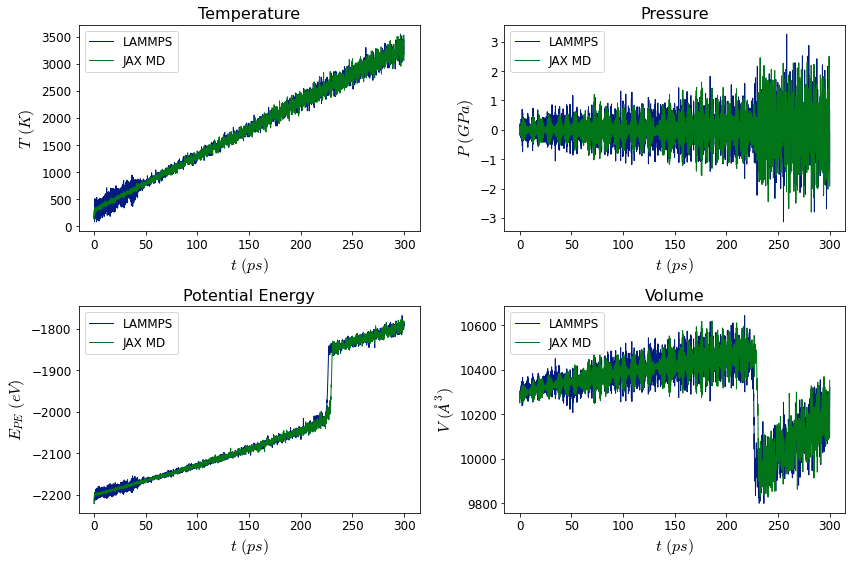

In [15]:
plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(t_l, T, lw=1, label='LAMMPS')
ax1.plot(t, log_r['kT'] / unit['temperature'], lw=1, label='JAX MD')
ax1.set_title('Temperature', fontsize=16)
ax1.set_ylabel("$T\ (K)$", fontsize=16)
ax1.set_xlabel("$t\ (ps)$", fontsize=16)
ax1.legend()

ax2 = plt.subplot(2, 2, 2)
ax2.plot(t_l, P/10000, lw=1, label='LAMMPS')
ax2.plot(t, (log_r['P'] / unit['pressure']) / 10000, lw=1, label='JAX MD')
ax2.set_title('Pressure', fontsize=16)
ax2.set_ylabel("$P\ (GPa)$", fontsize=16)
ax2.set_xlabel("$t\ (ps)$", fontsize=16)
ax2.legend()

ax3 = plt.subplot(2, 2, 3)
ax3.plot(t_l, E, lw=1, label='LAMMPS')
ax3.plot(t, log_r['E'], lw=1, label='JAX MD')
ax3.set_title('Potential Energy', fontsize=16)
ax3.set_ylabel("$E_{PE}\ (eV)$", fontsize=16)
ax3.set_xlabel("$t\ (ps)$", fontsize=16)
ax3.legend()

ax4 = plt.subplot(2, 2, 4)
ax4.plot(t_l, V, lw=1, label='LAMMPS')
ax4.plot(t, log_r['V'], lw=1, label='JAX MD')
ax4.set_title('Volume', fontsize=16)
ax4.set_ylabel("$V\  (\AA^3)$", fontsize=16)
ax4.set_xlabel("$t\ (ps)$", fontsize=16)
# ax4.set_ylim(jnp.mean(log_r['T']/512) - jnp.mean(log_r['T']/512)/1000 , jnp.mean(log_r['T']/512) + jnp.mean(log_r['T']/512)/1000)
ax4.legend()

fig.tight_layout()

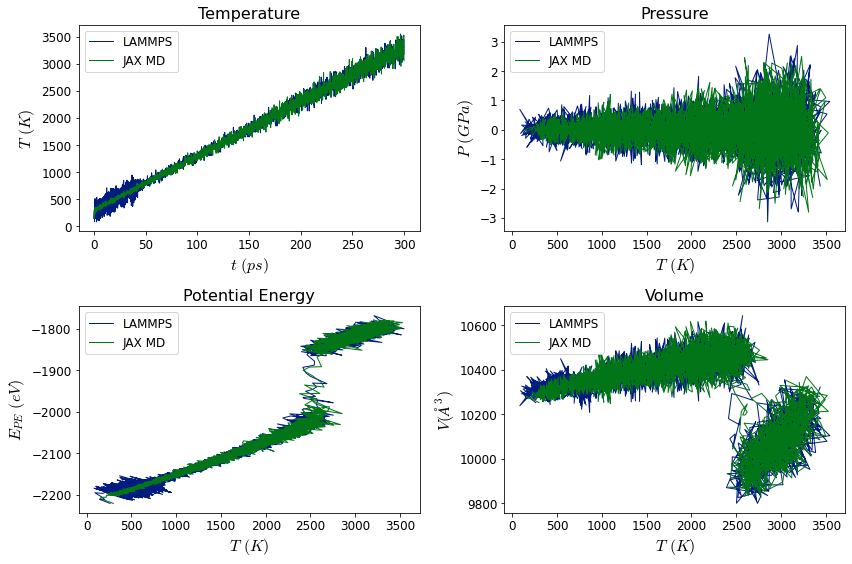

In [16]:
plt.style.use('seaborn-dark-palette')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(2, 2, 1)
ax1.plot(t_l, T, lw=1, label='LAMMPS')
ax1.plot(t, log_r['kT'] / unit['temperature'], lw=1, label='JAX MD')
ax1.set_title('Temperature', fontsize=16)
ax1.set_ylabel("$T\ (K)$", fontsize=16)
ax1.set_xlabel("$t\ (ps)$", fontsize=16)
ax1.legend()

ax2 = plt.subplot(2, 2, 2)
ax2.plot(T, P/10000, lw=1, label='LAMMPS')
ax2.plot(log_r['kT'] / unit['temperature'], (log_r['P'] / unit['pressure']) / 10000, lw=1, label='JAX MD')
ax2.set_title('Pressure', fontsize=16)
ax2.set_ylabel("$P\ (GPa)$", fontsize=16)
ax2.set_xlabel("$T\ (K)$", fontsize=16)
ax2.legend()

ax3 = plt.subplot(2, 2, 3)
ax3.plot(T, E, lw=1, label='LAMMPS')
ax3.plot(log_r['kT'] / unit['temperature'], log_r['E'], lw=1, label='JAX MD')
ax3.set_title('Potential Energy', fontsize=16)
ax3.set_ylabel("$E_{PE}\ (eV)$", fontsize=16)
ax3.set_xlabel("$T\ (K)$", fontsize=16)
ax3.legend()

ax4 = plt.subplot(2, 2, 4)
ax4.plot(T, V, lw=1, label='LAMMPS')
ax4.plot(log_r['kT'] / unit['temperature'], log_r['V'], lw=1, label='JAX MD')
ax4.set_title('Volume', fontsize=16)
ax4.set_ylabel("$V  (\AA^3)$", fontsize=16)
ax4.set_xlabel("$T\ (K)$", fontsize=16)
ax4.legend()

fig.tight_layout()